In [1]:
import os

import wandb
from tqdm import tqdm

api = wandb.Api()

datasets = ['airline', 'imdb', 'ssb', 'tpc_h', 'walmart', 'financial', 'basketball', 'accidents', 'movielens',
            'baseball', 'hepatitis', 'tournament', 'genome', 'credit', 'employee', 'carcinogenesis', 'consumer',
            'geneea', 'seznam', 'fhnk']

wandb_project = 'jwehrstein/udf_pullup_predictor'

def get_table_df(url: str, label: str):
    artifact = api.artifact(url)
    artifact.download()
    table = artifact.get(label)
    return table.get_dataframe()

def extract_dataset_from_name(name: str):
    candidates = []
    for dataset in datasets:
        if name.startswith(f'{dataset}_'):
            candidates.append(dataset)

    assert len(candidates) == 1, f'Found {len(candidates)} candidates for {name}'
    return candidates[0]


if os.path.exists('wandb_df_cache.pkl'):
    import pickle

    with open('wandb_df_cache.pkl', 'rb') as f:
        df_cache = pickle.load(f)
else:
    df_cache = dict()


def get_dataframes_from_run(run: str):
    if run in df_cache:
        print(f'Found run {run} in cache')
        return df_cache[run]

    df_dict = {}

    instance = api.run(f'{wandb_project}/{run}')
    dataset = extract_dataset_from_name(instance.displayName)

    if wandb.run is None:
        wandb.init()

    artifact_list = ['labels']
    for key in instance.summary.keys():
        if key.startswith('preds_'):
            artifact_list.append(key)
        
    
    for key in tqdm(artifact_list):
        df_dict[key] = get_table_df(f'{wandb_project}/run-{run}-{key}:latest', key)

    df_cache[run] = dataset, df_dict

    # save cache to file
    import pickle
    with open('wandb_df_cache.pkl', 'wb') as f:
        pickle.dump(df_cache, f)

    return dataset, df_dict

In [2]:
runs = [
    'gsf529wz', # genome
    'jpprixx0', # airline
    'in17r77q', # financial
    'vp855y95', # movielens
    't0dwq2ob', # fhnk
    '1w6btmy9', # employee
    'sqj5dmii', # ssb
    '8v7ifkb3', # baseball
    '4g64ovzi', # walmart
    '8szhvujd', # credit
    'maieekug', # consumer
    '2m5l11no', # tournament
    'd8x0tnl2', # carcinogenesis
    'dxikmxug', # seznam
    'in8ilklt', # geneea
    'k6aluvpu', # accidents
    'qifsk40g', # imdb
    'duqt5hx6', # hepatitis
    'munwxsgb', # basketball
    '7u03m5x0', # tpc_h
]


# initialize dictionaries
pullup_dicts = {}
pushdown_dicts = {}
pushdown_labels_dict = {}
pullup_labels_dict = {}
pushdown_sql_dict = {}
pullup_sql_dict = {}

for i, r in enumerate(runs):
    print(f'Processing run {r}: {i + 1}/{len(runs)}')
    try:
        dataset, df_dict = get_dataframes_from_run(r)
    except ValueError as e:
        print(e)
        continue

    assert dataset not in pullup_dicts, f'Dataset {dataset} already in pullup_dicts {pullup_dicts.keys()}'

    labels = df_dict['labels']
    preds_dict_pullup = dict()
    preds_dict_pushdown = dict()
    for key, value in df_dict.items():
        if key.startswith('preds_pullup'):
            preds_dict_pullup[key.replace('preds_pullup_', '')] = value
        elif key.startswith('preds_pushdown'):
            preds_dict_pushdown[key.replace('preds_pushdown_', '')] = value

    pullup_dicts[dataset] = preds_dict_pullup
    pushdown_dicts[dataset] = preds_dict_pushdown

    labels = dict(labels)

    pushdown_labels_dict[dataset] = labels['pushdown']
    pullup_labels_dict[dataset] = labels['pullup']
    pushdown_sql_dict[dataset] = labels['pushdown_sql']
    pullup_sql_dict[dataset] = labels['pullup_sql']


Processing run gsf529wz: 1/20
Found run gsf529wz in cache
Processing run jpprixx0: 2/20
Found run jpprixx0 in cache
Processing run in17r77q: 3/20
Found run in17r77q in cache
Processing run vp855y95: 4/20
Found run vp855y95 in cache
Processing run t0dwq2ob: 5/20
Found run t0dwq2ob in cache
Processing run 1w6btmy9: 6/20
Found run 1w6btmy9 in cache
Processing run sqj5dmii: 7/20
Found run sqj5dmii in cache
Processing run 8v7ifkb3: 8/20
Found run 8v7ifkb3 in cache
Processing run 4g64ovzi: 9/20
Found run 4g64ovzi in cache
Processing run 8szhvujd: 10/20
Found run 8szhvujd in cache
Processing run maieekug: 11/20
Found run maieekug in cache
Processing run 2m5l11no: 12/20
Found run 2m5l11no in cache
Processing run d8x0tnl2: 13/20
Found run d8x0tnl2 in cache
Processing run dxikmxug: 14/20
Found run dxikmxug in cache
Processing run in8ilklt: 15/20
Found run in8ilklt in cache
Processing run k6aluvpu: 16/20
Found run k6aluvpu in cache
Processing run qifsk40g: 17/20
Found run qifsk40g in cache
Proces

In [3]:
from ipywidgets import interact


def create_pull_push_label_plot(pullup_labels, pushdown_labels, dataset: str = None):
    # create statistic about pullup / pushdown runtime distribution
    import matplotlib.pyplot as plt

    tmp_pull = pullup_labels[:]
    tmp_push = pushdown_labels[:]

    # sort both lists by pushdown_labels
    tmp_pull = [x for _, x in sorted(zip(tmp_push, tmp_pull), key=lambda pair: pair[0])]
    tmp_push = sorted(tmp_push)

    # create barplot with both lists
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    barWidth = 0.4
    r1 = range(len(tmp_pull))
    r2 = [x + barWidth for x in r1]
    ax.bar(r1, tmp_pull, color='b', width=barWidth, label='Pullup')
    ax.bar(r2, tmp_push, color='r', width=barWidth, label='Pushdown')
    ax.set_xlabel(f'Query (id) - {len(tmp_pull)} queries')
    ax.set_ylabel('Runtime (s)')
    ax.set_title(f'Runtime of Pullup and Pushdown Plans ({dataset})')
    ax.set_xticks([r + barWidth / 2 for r in range(len(tmp_pull))])
    ax.set_xticklabels(range(1, len(tmp_pull) + 1))
    ax.legend()

    print(
        f'Max possible acceleration: {(sum(tmp_push) - sum([min(l1, l2) for l1, l2 in zip(tmp_pull, tmp_push)])) / sum(tmp_push) * 100:.2f}%')
    return plt


@interact(dataset=sorted(list(pullup_sql_dict.keys())))
def create_plot_for_dataset(dataset: str):
    create_pull_push_label_plot(pullup_labels_dict[dataset], pushdown_labels_dict[dataset], dataset=dataset)

interactive(children=(Dropdown(description='dataset', options=('accidents', 'airline', 'baseball', 'basketball…

Max possible acceleration: 44.67%


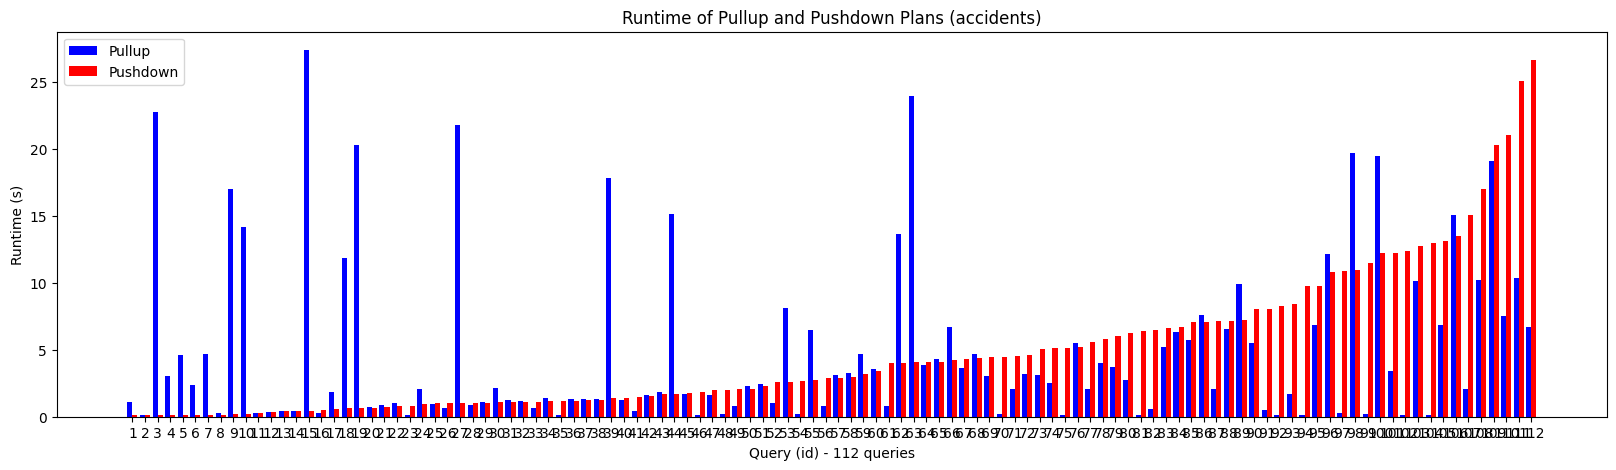

In [4]:
create_plot_for_dataset('accidents')

In [5]:
dataset = 'imdb'

potential_ids = []
for id in range(len(pullup_labels_dict[dataset])):
    # difference larger 2x
    if pullup_labels_dict[dataset][id] / pushdown_labels_dict[dataset][id] < 0.5:
        potential_ids.append(id)


def extract_num_joins_from_sql(sql: str):
    sql = sql.lower()
    sql = sql.split('from')[1]
    sql = sql.split('where')[0]

    return sql.count(' join ')


filtered_ids = []
for id in potential_ids:
    # filter out quries with more than 3 tables
    if extract_num_joins_from_sql(pushdown_sql_dict[dataset][id]) != 2:
        continue
    filtered_ids.append(id)
    print(f'{id}: {pushdown_sql_dict[dataset][id]}')

print(f'Found {len(filtered_ids)} queries with potential for pullup optimization')
for id in filtered_ids:
    print(f'{id}: {pullup_labels_dict[dataset][id]} vs {pushdown_labels_dict[dataset][id]}')

2: SELECT * FROM "movie_info" JOIN "title" ON "movie_info"."movie_id" = "title"."id" JOIN "movie_companies" ON "title"."id" = "movie_companies"."movie_id"  WHERE func_2710("movie_info"."id") >= 13253819 AND "movie_companies"."id" >= 969863 AND "movie_info"."info_type_id" >= 14 AND "title"."season_nr" >= 1.0 AND "movie_companies"."company_id" >= 8054;
6: SELECT * FROM "char_name" JOIN "cast_info" ON "char_name"."id" = "cast_info"."person_role_id" JOIN "title" ON "cast_info"."movie_id" = "title"."id"  WHERE func_3066("char_name"."id") <= 2951600 AND "cast_info"."movie_id" >= 545132 AND "cast_info"."person_id" <= 1033913 AND "title"."season_nr" <= 1.0;
15: SELECT AVG("movie_companies"."id" + "title"."production_year") as agg_0 FROM "movie_companies" JOIN "company_name" ON "movie_companies"."company_id" = "company_name"."id" JOIN "title" ON "movie_companies"."movie_id" = "title"."id"  WHERE func_2089("movie_companies"."id","movie_companies"."company_type_id","movie_companies"."company_id")

In [6]:
query_id = 185
print(f'Query {query_id}: {pushdown_sql_dict[dataset][query_id]}')
print(f'Pullup: {pullup_labels_dict[dataset][query_id]} vs Pushdown: {pushdown_labels_dict[dataset][query_id]}')
print(
    f'[Preds act] Pullup: {pullup_dicts[dataset]["act"]["None"][query_id]} vs Pushdown: {pushdown_dicts[dataset]["act"]["None"][query_id]}')
print(
    f'[Preds dd] Pullup: {pullup_dicts[dataset]["dd"]["None"][query_id]} vs Pushdown: {pushdown_dicts[dataset]["dd"]["None"][query_id]}')


Query 185: SELECT SUM("movie_keyword"."movie_id") as agg_0 FROM "movie_keyword" JOIN "keyword" ON "movie_keyword"."keyword_id" = "keyword"."id"  WHERE func_1973("movie_keyword"."id","movie_keyword"."movie_id") <= 1656193 AND "keyword"."id" >= 71237 AND "movie_keyword"."movie_id" <= 2009297;
Pullup: 1.3130215406417847 vs Pushdown: 1.389756441116333
[Preds act] Pullup: 1.2366318702697754 vs Pushdown: 1.262895941734314
[Preds dd] Pullup: 1.4723784923553467 vs Pushdown: 1.539454460144043


# Optimizers

In [7]:
import numpy as np
from typing import List, Dict


def optimal(preds_dict_pullup, preds_dict_pushdown, pullup_labels, pushdown_labels):
    # select the plan for which the runtime prediction is the lowest
    selections = [a < b for a, b in zip(pullup_labels, pushdown_labels)]

    return selections, sum(selections), sum(
        [a if decision else b for decision, a, b in zip(selections, pullup_labels, pushdown_labels)])


def greedy_avg(preds_dict_pullup, preds_dict_pushdown, pullup_labels, pushdown_labels, sel_list):
    # select the plan for which the avg cost prediction (across all selectivities) is the lowest
    avg_preds_pullup = [sum([preds_dict_pullup[sel][i] for sel in sel_list]) / len(sel_list) for i in
                        range(len(pullup_labels))]
    avg_preds_pushdown = [sum([preds_dict_pushdown[sel][i] for sel in sel_list]) / len(sel_list) for i in
                          range(len(pushdown_labels))]

    selections = [a < b for a, b in zip(avg_preds_pullup, avg_preds_pushdown)]

    return selections, sum(selections), sum(
        [a if decision else b for decision, a, b in zip(selections, pullup_labels, pushdown_labels)])


def avoid_worst(preds_dict_pullup, preds_dict_pushdown, pullup_labels, pushdown_labels, sel_list):
    # select the plan for which the avg cost prediction (across all selectivities) is the lowest
    max_preds_pullup = [max([preds_dict_pullup[sel][i] for sel in sel_list]) for i in
                        range(len(pullup_labels))]
    max_preds_pushdown = [sum([preds_dict_pushdown[sel][i] for sel in sel_list]) / len(sel_list) for i in
                          range(len(pushdown_labels))]

    selections = [a < b for a, b in zip(max_preds_pullup, max_preds_pushdown)]

    return selections, sum(selections), sum(
        [a if decision else b for decision, a, b in zip(selections, pullup_labels, pushdown_labels)])


def single_sel(preds_dict_pullup, preds_dict_pushdown, pullup_labels, pushdown_labels, sel: str = 'None',
               improvement_factor: float = 1.0):
    # select the plan for which the sel50 prediction is the lowest
    sel_preds_pullup = [preds_dict_pullup[sel][i] for i in
                        range(len(pullup_labels))]
    sel_preds_pushdown = [preds_dict_pushdown[sel][i] for i in
                          range(len(pushdown_labels))]

    selections = [a * improvement_factor < b for a, b in zip(sel_preds_pullup, sel_preds_pushdown)]

    return selections, sum(selections), sum(
        [a if decision else b for decision, a, b in zip(selections, pullup_labels, pushdown_labels)])


def random_sel(preds_dict_pullup, preds_dict_pushdown, pullup_labels, pushdown_labels):
    import random
    # set random seed
    random.seed(42)
    selections = [random.choice([True, False]) for _ in range(len(pullup_labels))]

    return selections, sum(selections), sum(
        [a if decision else b for decision, a, b in zip(selections, pullup_labels, pushdown_labels)])


def always_push(preds_dict_pullup, preds_dict_pushdown, pullup_labels, pushdown_labels):
    return [False] * len(pullup_labels), 0, sum(pushdown_labels)


def area_under_curve(preds_dict_pullup, preds_dict_pushdown, pullup_labels, pushdown_labels, sel_list):
    # select the plan for which the area under the curve is the lowest
    assert sel_list[-1] == 'None', 'Last element of sel_list must be None (i.e. sel 1.0)'

    def calc_auc(preds_dict: Dict, sel_list: List[str]):
        area = None

        for i in range(len(sel_list)):
            if i == 0:
                start_key = sel_list[i]
                start_bound = float(sel_list[i]) / 100
            else:
                start_key = sel_list[i - 1]
                start_bound = float(sel_list[i - 1]) / 100

            if i == len(sel_list) - 1:
                end_bound = 1
            else:
                end_bound = float(sel_list[i]) / 100

            end_key = sel_list[i]

            iteration = (end_bound - start_bound) * (
                    np.asarray(preds_dict[end_key]) + np.asarray(preds_dict[start_key])) / 2
            if area is None:
                area = iteration
            else:
                area += iteration

        return area

    pull_aucs = calc_auc(preds_dict_pullup, sel_list)
    push_aucs = calc_auc(preds_dict_pushdown, sel_list)

    selections = [a < b for a, b in zip(pull_aucs, push_aucs)]

    return selections, sum(selections), sum(
        [a if decision else b for decision, a, b in zip(selections, pullup_labels, pushdown_labels)])


def conservative(preds_dict_pullup, preds_dict_pushdown, pullup_labels, pushdown_labels, sel_list):
    # select only a pullup plan if it is faster than the pushdown plan for all selectivities
    pullup_faster = [all([preds_dict_pullup[sel][i] < preds_dict_pushdown[sel][i] for sel in sel_list]) for i in
                     range(len(pullup_labels))]
    selections = pullup_faster

    return selections, sum(selections), sum(
        [a if decision else b for decision, a, b in zip(selections, pullup_labels, pushdown_labels)])


def greedy_min(preds_dict_pullup, preds_dict_pushdown, pullup_labels, pushdown_labels, sel_list):
    # select only a pullup plan if it is faster than the pushdown plan for all selectivities
    selections = [
        min([preds_dict_pullup[sel][i] for sel in sel_list]) < min([preds_dict_pushdown[sel][i] for sel in sel_list])
        for i in range(len(pullup_labels))]

    return selections, sum(selections), sum(
        [a if decision else b for decision, a, b in zip(selections, pullup_labels, pushdown_labels)])


def calc_f1(selections, gold_standard_selections):
    assert len(selections) == len(gold_standard_selections)

    # calculate f1 score
    tp = sum([1 for p, l in zip(selections, gold_standard_selections) if p and l])
    tn = sum([1 for p, l in zip(selections, gold_standard_selections) if not p and not l])
    fp = sum([1 for p, l in zip(selections, gold_standard_selections) if p and not l])
    fn = sum([1 for p, l in zip(selections, gold_standard_selections) if not p and l])

    if tp + fp == 0:
        precision = 1
    else:
        precision = tp / (tp + fp)
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    accuracy = (tp + tn) / len(selections)

    return precision, recall, f1, accuracy, tp / len(selections)


def calc_regression(selections, gold_standard_selections, pullup_labels, pushdown_labels, overall_runtime):
    assert len(selections) == len(gold_standard_selections)

    # extract all entries where selections is true but gold_standard_selections is false
    false_positives_runtimes = [pullup_label for sel, true_sel, pullup_label in
                                zip(selections, gold_standard_selections, pullup_labels) if sel and not true_sel]

    # calculate average slowdown of false positives (in percentage)
    false_positives_ideal_runtimes = [pushdown_label for sel, true_sel, pushdown_label in
                                      zip(selections, gold_standard_selections, pushdown_labels) if
                                      sel and not true_sel]

    # regression
    fp_difference = [a - b for a, b in zip(false_positives_runtimes, false_positives_ideal_runtimes)]

    if len(false_positives_runtimes) == 0:
        avg_regression_slowdown_perc = 0
    else:
        avg_regression_slowdown_perc = sum(
            [(a - b) / b for a, b in zip(false_positives_runtimes, false_positives_ideal_runtimes)]) / len(
            false_positives_runtimes)

    # fp percentage, difference by fp choice (regression in %), total sum of regression, avg regression in %
    return len(false_positives_runtimes) / len(selections), sum(fp_difference) / overall_runtime, sum(
        fp_difference), avg_regression_slowdown_perc

# Apply Optimizers

In [8]:
from collections import defaultdict
import functools

sel_list = ['10', '30', '50', '70', '90', 'None']
# solvers
solvers = [functools.partial(greedy_avg, sel_list=sel_list),
           functools.partial(avoid_worst, sel_list=sel_list), random_sel,
           functools.partial(area_under_curve, sel_list=sel_list)]
solver_names = ['greedy_avg', 'avoid_worst', 'auc']

result_dicts = dict()
gold_standards_dict = dict()
selections_dicts = defaultdict(dict)
baseline_runtimes = dict()

key_set = set()

for dataset_key in pullup_sql_dict.keys():
    preds_dict_pullup = pullup_dicts[dataset_key]
    preds_dict_pushdown = pushdown_dicts[dataset_key]
    pullup_labels = pullup_labels_dict[dataset_key]
    pushdown_labels = pushdown_labels_dict[dataset_key]

    pushdown_rt = sum(pushdown_labels)
    baseline_runtimes[dataset_key] = pushdown_rt
    gold_standards_dict[dataset_key] = [a < b for a, b in zip(pullup_labels, pushdown_labels)]

    greedy_fn = functools.partial(greedy_avg, sel_list=sel_list)
    greedy_fn.__name__ = 'greedy_avg'

    auc_fn = functools.partial(area_under_curve, sel_list=sel_list)
    auc_fn.__name__ = 'auc'

    sel_30_fn = functools.partial(single_sel, sel='30')
    sel_30_fn.__name__ = 'single_sel(30)'

    con_fn = functools.partial(conservative, sel_list=sel_list)
    con_fn.__name__ = 'conservative'

    greedymin_fn = functools.partial(greedy_min, sel_list=sel_list)
    greedymin_fn.__name__ = 'greedymin'

    experiments = [
        (single_sel, 'act', 'act'),
        (single_sel, 'wj', 'dd'),
        (single_sel, 'wj', 'wj'),
        (single_sel, 'dd', 'dd'),
        (single_sel, 'est', 'est'),
        (sel_30_fn, 'dd', 'dd'),
        # (sel_30_fn,'wj','dd'),
        (sel_30_fn, 'est', 'est'),
        (optimal, None, None),
        (always_push, None, None),
        (random_sel, None, None),
        (greedy_fn, 'est', 'est'),
        (greedy_fn, 'dd', 'dd'),
        (auc_fn, 'est', 'est'),
        (auc_fn, 'dd', 'dd'),
        # (auc_fn,'wj','dd'),
        (auc_fn, 'wj', 'wj'),
        (con_fn, 'est', 'est'),
        (con_fn, 'dd', 'dd'),
        # (con_fn,'wj','dd'),
        (con_fn, 'wj', 'wj'),
        (greedymin_fn, 'est', 'est'),
        (greedymin_fn, 'dd', 'dd'),
        (greedymin_fn, 'wj', 'wj'),
    ]

    results = dict()
    for entry in experiments:
        if (entry[1] is not None and entry[1] not in preds_dict_pullup) or (
                entry[2] is not None and entry[2] not in preds_dict_pushdown):
            print(f'Skipping {entry[0].__name__} / {entry[1]} / {entry[2]} for {dataset_key} because of missing data')
            continue

        if entry[1] is None:
            preds_pullup = None
        else:
            assert entry[1] in preds_dict_pullup, f'Key {entry[1]} not in preds_dict_pullup: {preds_dict_pullup.keys()}'
            preds_pullup = preds_dict_pullup[entry[1]]
        if entry[2] is None:
            preds_pushdown = None
        else:
            preds_pushdown = preds_dict_pushdown[entry[2]]

        name = entry[0].__name__ if entry[0].__name__ != '<lambda>' else entry[0].func.__name__
        key = (name, entry[1], entry[2])
        selections, num_pullups, runtime = entry[0](preds_pullup, preds_pushdown, pullup_labels, pushdown_labels)

        precision, recall, f1, accuracy, tp_percentage= calc_f1(selections, gold_standards_dict[dataset_key])

        fp_percentage, regression_in_total_runtime_rel, regression_in_total_runtime_abs, if_regression_how_worse_avg = calc_regression(
            selections, gold_standards_dict[dataset_key], pullup_labels_dict[dataset_key],
            pushdown_labels_dict[dataset_key], runtime)

        results[key] = {
            'runtime': runtime,
            'num_pullups': num_pullups,
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy,
            'impr_over_duckdb': (pushdown_rt - runtime) / pushdown_rt,
            'tp_percentage':tp_percentage,
            'fp_percentage': fp_percentage,
            'regression_in_total_runtime_rel': regression_in_total_runtime_rel,
            'regression_in_total_runtime_abs': regression_in_total_runtime_abs,
            'if_regression_how_worse_avg': if_regression_how_worse_avg
        }

        key_set.add(key)

        assert key not in selections_dicts[dataset_key]
        selections_dicts[dataset_key][key] = selections

    result_dicts[dataset_key] = results

Skipping single_sel / wj / wj for airline because of missing data
Skipping auc / wj / wj for airline because of missing data
Skipping conservative / wj / wj for airline because of missing data
Skipping greedymin / wj / wj for airline because of missing data


In [9]:
@interact(dataset=sorted(list(pullup_sql_dict.keys())))
def list_results_for_dataset(dataset: str):
    tabulate_data = []
    results = result_dicts[dataset]
    for key, value in results.items():
        tabulate_data.append((f'{key[0]} ({key[1]},{key[2]})', value['num_pullups'], value['runtime'],
                              f'{value["impr_over_duckdb"]:.2%}', value['precision'], value['recall'], value['f1'],
                              f'{value["accuracy"]:.2%}',
                              f'{value["fp_percentage"]:.2%}', f'{value["regression_in_total_runtime_rel"]:.2%}',
                              f'{value["regression_in_total_runtime_abs"]:.2f}',
                              f'{value["if_regression_how_worse_avg"]:.2%}'))

    # sort by runtime
    tabulate_data = sorted(tabulate_data, key=lambda x: x[2])

    import tabulate
    print(tabulate.tabulate(tabulate_data,
                            headers=['Solver', 'Pullups', 'Runtime', 'Improvement\nover DuckDB', 'Precision', 'Recall',
                                     'F1', 'Accuracy', 'FP Perc.', 'Regression in total\nruntime (rel)',
                                     'Regression in total\nruntime (abs)',
                                     'If Regression: how worse? \n(relative + on average)']))

interactive(children=(Dropdown(description='dataset', options=('accidents', 'airline', 'baseball', 'basketball…

# Plot overview of all datasets

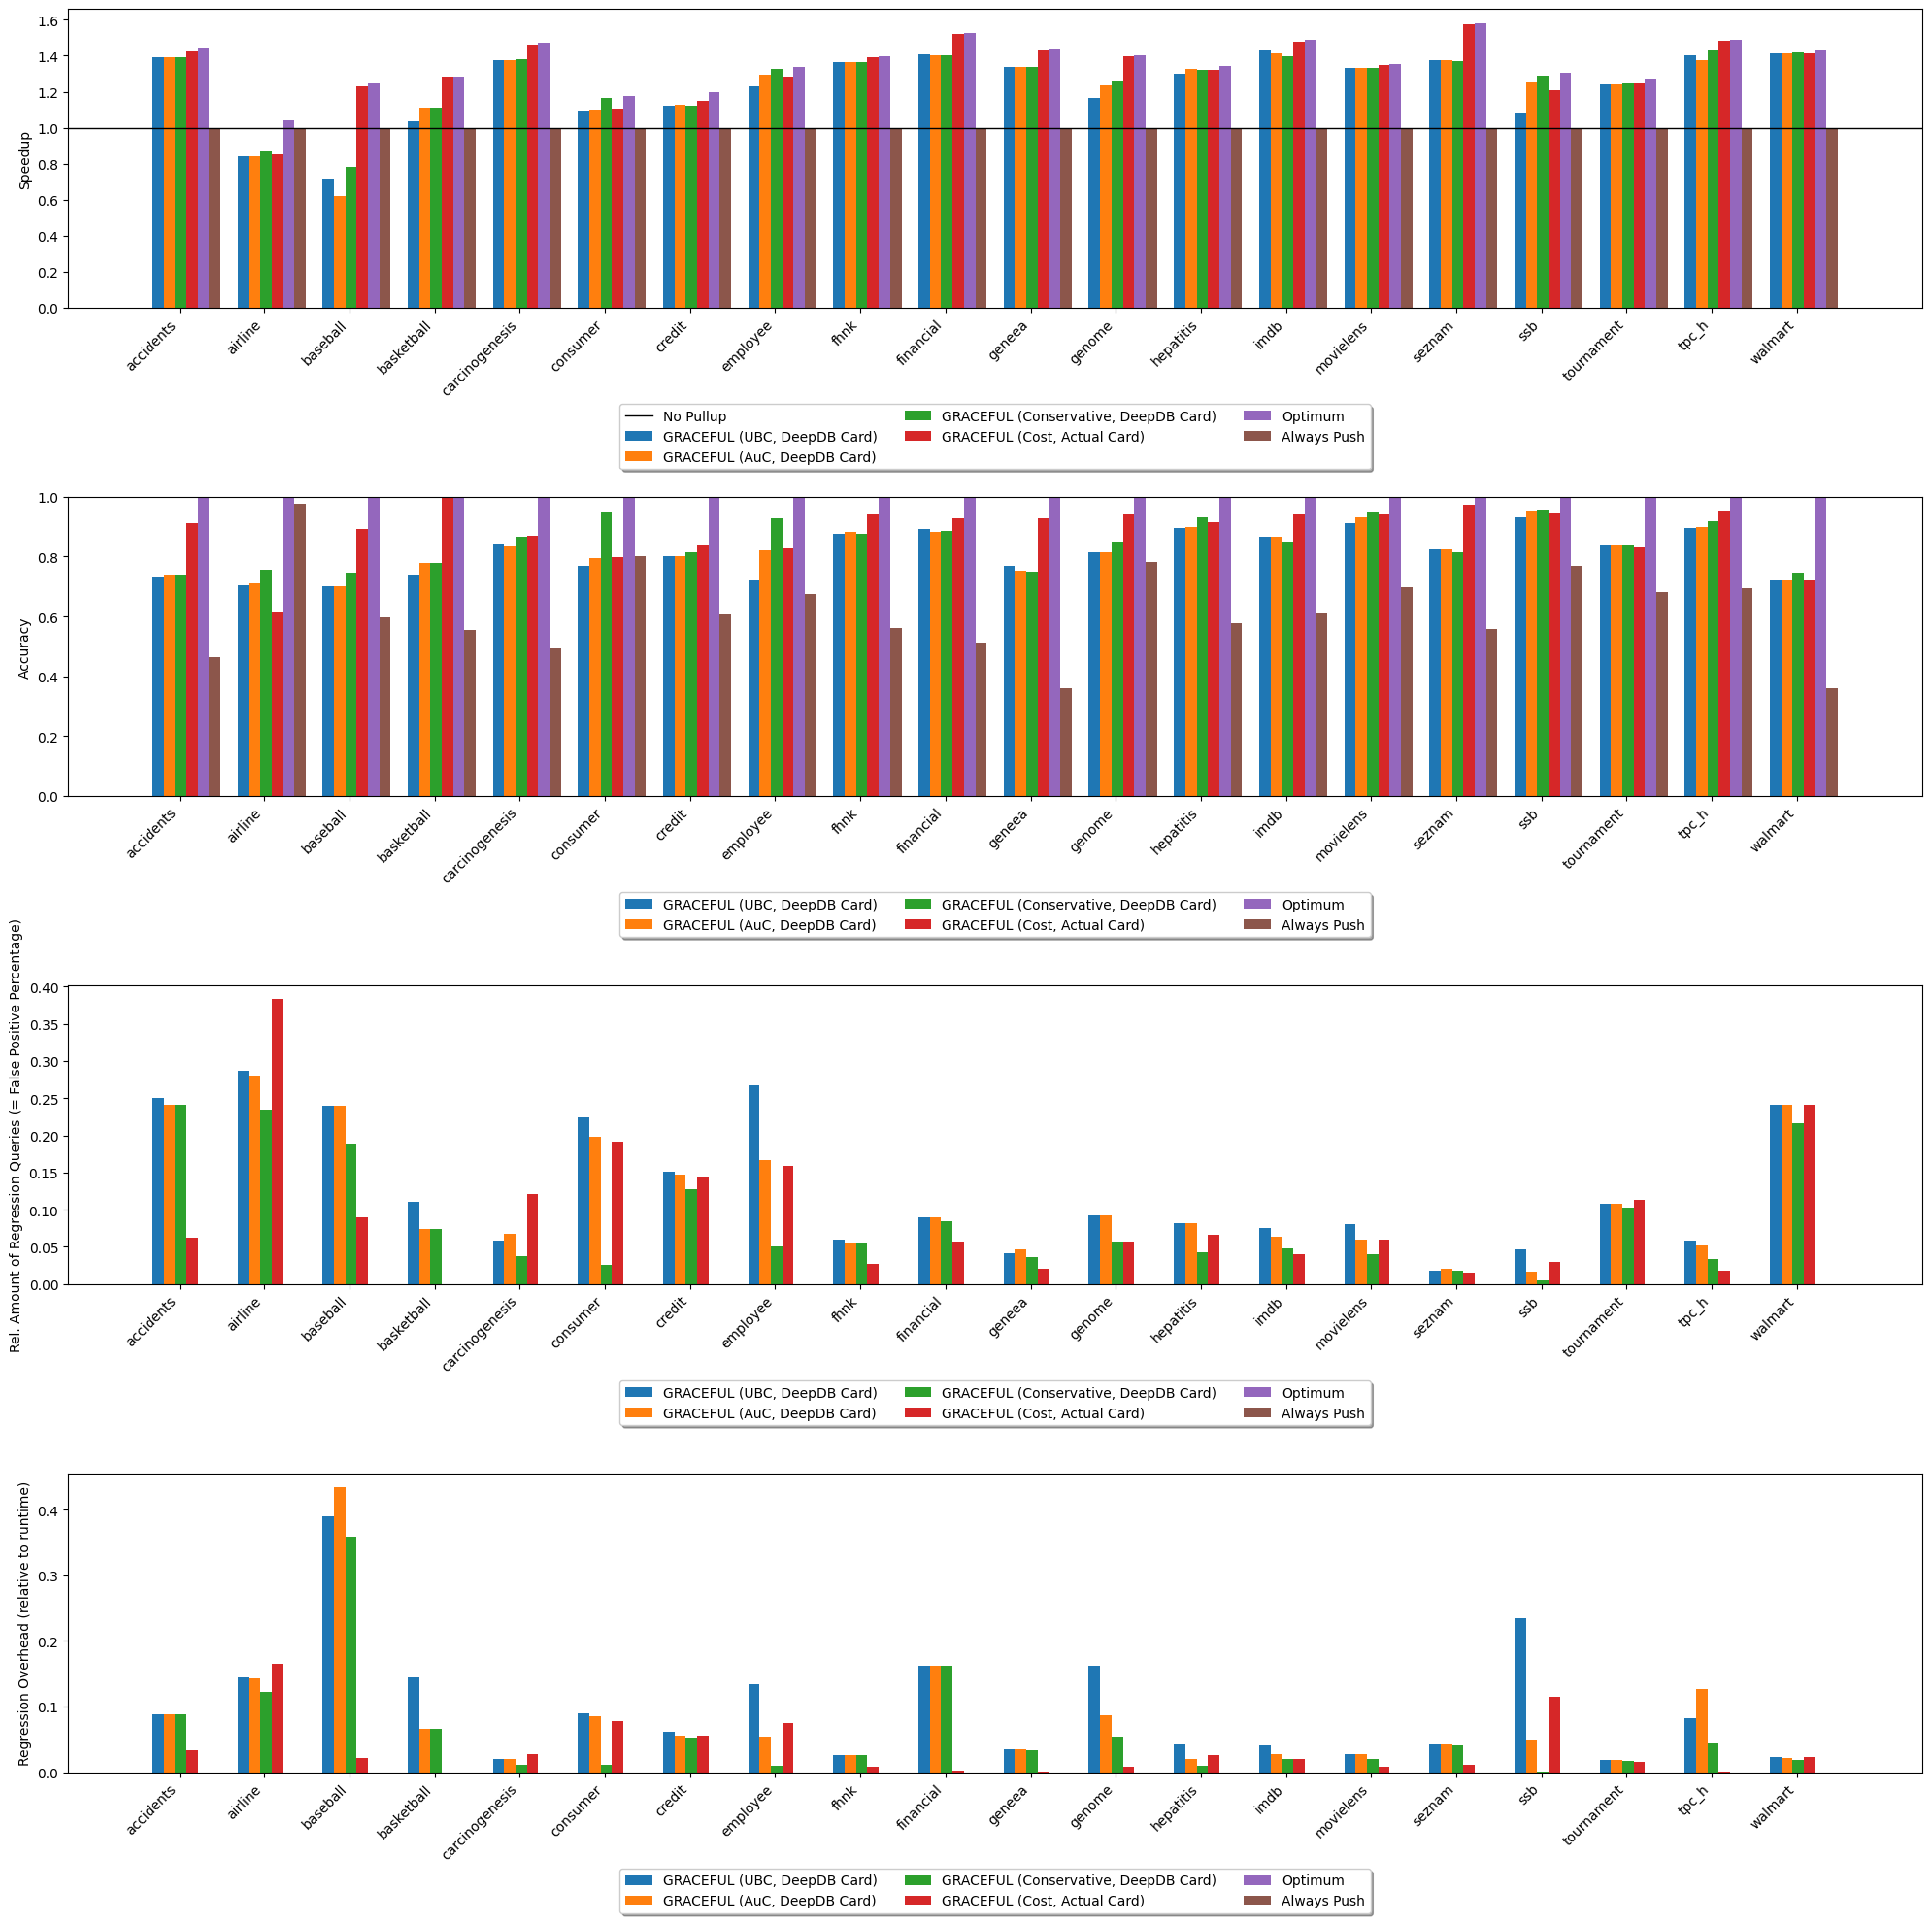

Speedup statistics (Avg. over all 20 datasets)
Card    Solver          Avg. Speedup    Min Speedup    Max Speedup    Median Speedup  FP Percentage    FP Impact (relative to total runtime)
------  ------------  --------------  -------------  -------------  ----------------  ---------------  ---------------------------------------
        Optimal              1.36121       1.04002         1.58201           1.37542  0.00%            0.00%
Actual  Cost                 1.33018       0.851235        1.57666           1.36967  9.48%            3.47%
DeepDB  Conservative         1.26576       0.779723        1.42882           1.33074  8.58%            5.82%
DeepDB  AuC                  1.2471        0.619341        1.41523           1.32862  11.71%           7.93%
DeepDB  UBC                  1.23339       0.718952        1.4287            1.3161   12.90%           9.83%
        Always Push          1             1               1                 1        0.00%            0.00%


In [10]:
from typing import Tuple
import tabulate

datasets = []
import matplotlib.pyplot as plt

speedup_dict = defaultdict(dict)
acc_dict = defaultdict(dict)
tp_percentage = defaultdict(dict)
fp_percentage = defaultdict(dict)
regression_overhead = defaultdict(dict)
runtime = defaultdict(dict)

def process(key: Tuple, card: str, solver: str, label:str, results: Dict, dataset: str):
    out_key = (card, solver, label)
    if key not in results:
        speedup_dict[out_key][dataset] = np.nan
        acc_dict[out_key][dataset] = np.nan
        tp_percentage[out_key][dataset] = np.nan
        fp_percentage[out_key][dataset] = np.nan
        regression_overhead[out_key][dataset] = np.nan
        runtime[out_key][dataset] = np.nan
    else:
        speedup_dict[out_key][dataset] = results[key]['impr_over_duckdb'] + 1  # convert improvement to speedup
        acc_dict[out_key][dataset] = results[key]['accuracy']
        tp_percentage[out_key][dataset] = results[key]['tp_percentage']
        fp_percentage[out_key][dataset] = results[key]['fp_percentage']
        regression_overhead[out_key][dataset] = results[key]['regression_in_total_runtime_rel']
        runtime[out_key][dataset] = results[key]['runtime']

for dataset in sorted(list(pullup_sql_dict.keys())):
    datasets.append(dataset)

    results = result_dicts[dataset]

    # process(('single_sel', 'est', 'est'), 'DuckDB','Cost', results, dataset)
    # process(('conservative', 'est', 'est'), 'DuckDB','Conservative', results=results, dataset=dataset)
    process(('single_sel', 'dd', 'dd'), 'DeepDB', 'UBC','GRACEFUL (UBC, DeepDB Card)', results, dataset=dataset)
    process(('auc', 'dd', 'dd'), 'DeepDB', 'AuC', 'GRACEFUL (AuC, DeepDB Card)', results=results, dataset=dataset)
    process(('conservative', 'dd', 'dd'), 'DeepDB', 'Conservative','GRACEFUL (Conservative, DeepDB Card)', results=results, dataset=dataset)
    # process(('single_sel', 'wj', 'dd'), 'Card: WJ / DeepDB (Cost)', results=results, dataset=dataset)
    # process(('auc', 'wj', 'dd'), 'Card: WJ / DeepDB (AuC)', results=results, dataset=dataset)
    # process(('conservative', 'wj', 'dd'), 'Card: WJ / DeepDB (Conservative)', results=results, dataset=dataset)
    # process(('single_sel', 'wj', 'wj'), 'WJ','Cost', results=results, dataset=dataset)
    # process(('auc', 'wj', 'wj'), 'WJ','AuC', results=results, dataset=dataset)
    # process(('conservative', 'wj', 'wj'), 'WJ','Conservative', results=results, dataset=dataset)
    # process(('greedymin', 'wj', 'wj'), 'Card: WJ (GreedyMin)', results=results, dataset=dataset)
    process(('single_sel', 'act', 'act'), 'Actual', 'Cost','GRACEFUL (Cost, Actual Card)', results=results, dataset=dataset)
    process(('optimal', None, None), '', 'Optimal','Optimum', results=results, dataset=dataset)
    process(('always_push',None,None),'', 'Always Push', 'Always Push', results=results, dataset=dataset)

dataset = sorted(datasets)
# datasets = sorted(datasets, key=lambda x: speedup_dict[('','Optimal')][x])

# create barplot with both lists
plt.close()
fig, axs = plt.subplots(4, 1, figsize=(20, 20))
barWidth = 0.8 / len(speedup_dict)

dicts = [speedup_dict, acc_dict, fp_percentage, regression_overhead]
metrics = ['Speedup', 'Accuracy', 'Rel. Amount of Regression Queries (= False Positive Percentage)',
           'Regression Overhead (relative to runtime)']

for i in range(len(dicts)):
    value_dict = dicts[i]
    metric = metrics[i]
    ax = axs[i]

    for i, key in enumerate(value_dict.keys()):
        # if key[0] == '':
        #     label = key[1]
        # else:
        #     label = f'{key[1]} (Card: {key[0]})'
        label = key[2]
        ax.bar([x + i * barWidth for x in range(len(value_dict[key]))],
               [value_dict[key][dataset] for dataset in datasets], width=barWidth, label=label)

    # draw line at y = 1
    if metric == 'Speedup':
        ax.axhline(y=1, color='black', linestyle='-', label='No Pullup', linewidth=1)

    # ax.set_xlabel(f'Datasets')
    ax.set_ylabel(f'{metric}')

    ax.set_xticks([r + 0.25 for r in range(len(datasets))])
    ax.set_xticklabels(datasets, rotation=45, ha='right')

    # set title
    # ax.set_title(f'{metric} of different pullup/pushdown advisors compared to DuckDB')

    # set y lim to 1
    # ax.set_ylim(1, max([max(l) for l in runtime_list_dict.values()]) + 0.1)
    if metric == 'Accuracy':
        ax.set_ylim(0, 1)

    # place legend below chart
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), shadow=True, ncol=3)

# add space between subplots
plt.tight_layout()

plt.show()

tabulate_data = []
for key, vals in speedup_dict.items():
    vs = [v for v in vals.values() if not np.isnan(v)]
    regression_overheads = [v for v in regression_overhead[key].values() if not np.isnan(v)]
    fp_percentages = [v for v in fp_percentage[key].values() if not np.isnan(v)]
    tabulate_data.append((key[0], key[1], sum(vs) / len(vs), min(vs), max(vs), np.median(vs),
                          f'{sum(fp_percentages) / len(fp_percentages):.2%}',
                          f'{sum(regression_overheads) / len(regression_overheads):.2%}'))

tabulate_data.sort(key=lambda x: x[2], reverse=True)

print('Speedup statistics (Avg. over all 20 datasets)')
print(tabulate.tabulate(tabulate_data,
                        headers=['Card', 'Solver', 'Avg. Speedup', 'Min Speedup', 'Max Speedup', 'Median Speedup',
                                 'FP Percentage', 'FP Impact (relative to total runtime)']))

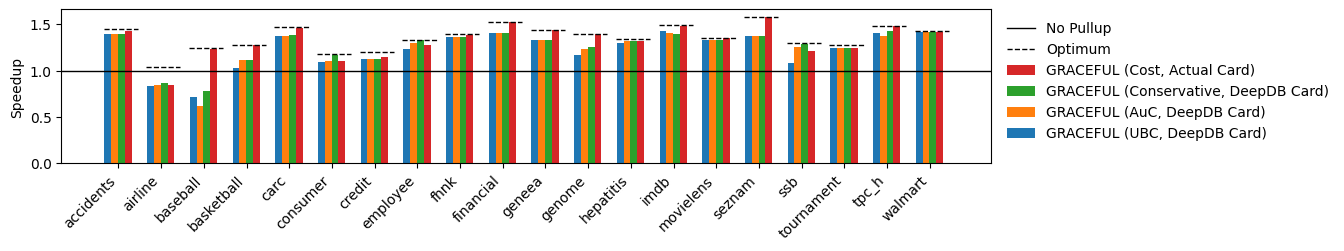

Speedup statistics (Avg. over all 20 datasets)
Card    Solver          Avg. Speedup    Min Speedup    Max Speedup    Median Speedup  TP Percentage    FP Percentage    FP Impact (relative to total runtime)      Total Runtime
------  ------------  --------------  -------------  -------------  ----------------  ---------------  ---------------  ---------------------------------------  ---------------
        Optimal              1.36121       1.04002         1.58201           1.37542  38.34%           0.00%            0.00%                                            11096.1
Actual  Cost                 1.33018       0.851235        1.57666           1.36967  36.53%           9.48%            3.47%                                            11581.6
DeepDB  Conservative         1.26576       0.779723        1.42882           1.33074  31.69%           8.58%            5.82%                                            12455.2
DeepDB  AuC                  1.2471        0.619341        1.41523  

In [11]:
dicts = [speedup_dict]
metrics = ['Speedup']

# create barplot with both lists
plt.close()
fig, axs = plt.subplots(len(dicts), 1, figsize=(12, len(dicts) * 2))
barWidth = 0.8 / (len(speedup_dict)-1)

dataset_abbreviations = {
    'carcinogenesis':'carc'
}

for i in range(len(dicts)):
    value_dict = dicts[i].copy()
    metric = metrics[i]

    ax = axs
    
    optimum_key = ('','Optimal','Optimum')
    if optimum_key in value_dict:
        optimum_speedup = value_dict.pop(optimum_key)

    for i, key in enumerate(value_dict.keys()):

        label = key[2]
        if 'duckdb' in label.lower() or 'always push' in label.lower():
            continue
        # print(label)

        ax.bar([x + i * barWidth for x in range(len(value_dict[key]))],
               [value_dict[key][dataset] for dataset in datasets], width=barWidth, label=label)
        
    # draw optimum line
    for i,dataset in enumerate(datasets):
        ax.hlines(y=optimum_speedup[dataset], xmin=i-.1, xmax=i+0.7, colors='black', linestyles='dashed', label='Optimum', linewidth=1)

    # draw line at y = 1
    if metric == 'Speedup':
        ax.axhline(y=1, color='black', linestyle='-', label='No Pullup', linewidth=1)

    # ax.set_xlabel(f'Datasets')
    ax.set_ylabel(f'{metric}')

    ax.set_xticks([r + 0.25 for r in range(len(datasets))])

    abbreviated_datasets = [dataset_abbreviations[dataset] if dataset in dataset_abbreviations else dataset for dataset in datasets]
    ax.set_xticklabels(abbreviated_datasets, rotation=45, ha='right')

    # set title
    # ax.set_title(f'{metric} of different pullup/pushdown advisors compared to DuckDB')

    # set y lim to 1
    # ax.set_ylim(1, max([max(l) for l in runtime_list_dict.values()]) + 0.1)
    if metric == 'Accuracy':
        ax.set_ylim(0, 1)

    # place legend below chart
    handles, plot_labels = ax.get_legend_handles_labels()
    
    handles=handles[19:]
    plot_labels = plot_labels[19:]
    
    order = [1,0,5,4,3,2]
    # ax.legend([handles[idx] for idx in order], [plot_labels[idx] for idx in order], loc='upper center', bbox_to_anchor=(0.5, -0.45), shadow=False, ncol=3, frameon=False)
    ax.legend([handles[idx] for idx in order], [plot_labels[idx] for idx in order], loc='upper center', bbox_to_anchor=(1.19, 1), shadow=False, ncol=1, frameon=False)
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=3, shadow=False, frameon=False, )
    

plt.show()
fig.savefig('results/pullup_pushdown_speedup.pdf', bbox_inches='tight')

tabulate_data = []
for key, vals in speedup_dict.items():
    vs = [v for v in vals.values() if not np.isnan(v)]
    regression_overheads = [v for v in regression_overhead[key].values() if not np.isnan(v)]
    tp_percentages = [v for v in tp_percentage[key].values() if not np.isnan(v)]
    fp_percentages = [v for v in fp_percentage[key].values() if not np.isnan(v)]
    runtimes = [v for v in runtime[key].values() if not np.isnan(v)]
    tabulate_data.append((key[0], key[1], sum(vs) / len(vs), min(vs), max(vs), np.median(vs),
                          f'{sum(tp_percentages) / len(tp_percentages):.2%}',
                          f'{sum(fp_percentages) / len(fp_percentages):.2%}',
                          f'{sum(regression_overheads) / len(regression_overheads):.2%}',sum(runtimes)))

tabulate_data.sort(key=lambda x: x[2], reverse=True)

print('Speedup statistics (Avg. over all 20 datasets)')
print(tabulate.tabulate(tabulate_data,
                        headers=['Card', 'Solver', 'Avg. Speedup', 'Min Speedup', 'Max Speedup', 'Median Speedup','TP Percentage',
                                 'FP Percentage', 'FP Impact (relative to total runtime)','Total Runtime']))

# Analyze entries

In [12]:

import matplotlib.pyplot as plt
from ipywidgets import interact


@interact(dataset=sorted(list(selections_dicts.keys())), query_id=(0, len(pullup_labels_dict[dataset]) - 1),
          card_pull=['None', 'wj', 'dd', 'est'], card_push=['None', 'wj', 'dd', 'est'])
def analyze(query_id: int, card_pull: str, card_push: str, dataset: str):
    tmp_sel_list = [sel for sel in sel_list if sel in pullup_dicts[dataset][card_pull]]

    sel_list_cleaned = [int(sel) / 100 if sel != 'None' else 1 for sel in tmp_sel_list]
    sel_preds_pullup = [pullup_dicts[dataset][card_pull][sel][query_id] for sel in tmp_sel_list]
    sel_preds_pushdown = [pushdown_dicts[dataset][card_push][sel][query_id] for sel in tmp_sel_list]
    label_pullup = pullup_labels_dict[dataset][query_id]
    label_pushdown = pushdown_labels_dict[dataset][query_id]

    print(
        f'Query {query_id}: pullup: {label_pullup} vs pushdown: {label_pushdown}, sql: {pushdown_sql_dict[dataset][query_id]}')

    # create barplot with both lists
    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    barWidth = 0.4
    r1 = range(len(sel_preds_pullup))
    r2 = [x + barWidth for x in r1]
    ax.bar(r1, sel_preds_pullup, color='b', width=barWidth, label='Pullup (predictions)')
    ax.bar(r2, sel_preds_pushdown, color='r', width=barWidth, label='Pushdown (predictions)')
    ax.set_xlabel('UDF Filter Selectivity (outgoing tuples / incoming tuples)')
    ax.set_ylabel('Runtime (s)')
    ax.set_title(f'Runtime of Pullup and Pushdown Plans for Query {query_id} ({dataset}/{card_pull}/{card_push})')
    ax.set_xticks([r + barWidth / 2 for r in range(len(sel_preds_pullup))], sel_list_cleaned)
    plt.axhline(y=label_pullup, color='b', label='Pullup Runtime', linestyle='--')
    plt.axhline(y=label_pushdown, color='r', label='Pushdown Runtime', linestyle='--')
    ax.legend()
    plt.show()

interactive(children=(IntSlider(value=41, description='query_id', max=82), Dropdown(description='card_pull', o…

In [13]:
import statistics
from ipywidgets import interact
import tabulate


@interact(dataset=sorted(list(selections_dicts.keys())), instance=sorted(list(key_set)))
def analyze_worst_entries(dataset: str, instance):
    pullup_pushdown_diff = [a - b for a, b in zip(pullup_labels_dict[dataset], pushdown_labels_dict[dataset])]
    selection_under_test = selections_dicts[dataset][instance]
    deviation_from_optimal = []
    for id, sut, sopt in zip(range(len(selection_under_test)), selection_under_test, gold_standards_dict[dataset]):
        if sut != sopt:
            deviation_from_optimal.append(pullup_pushdown_diff[id])
        else:
            deviation_from_optimal.append(0)

    data = zip(deviation_from_optimal, range(len(deviation_from_optimal)), pullup_labels_dict[dataset],
               pushdown_labels_dict[dataset], selection_under_test, pullup_dicts[dataset][instance[1]]['None'],
               pushdown_dicts[dataset][instance[2]]['None'])
    headers = ['Difference in seconds between opt. and actual selection\n(+ pushdown is faster, - pullup is faster)',
               'Query ID', 'Pullup label', 'Pushdown label', 'Selection by solver', 'pullup est', 'pushdown est']

    # print the max 10 entries with the highest deviation from the optimal solution and the corresponding query id
    max_deviation = sorted(data, key=lambda x: abs(x[0]), reverse=True)[:10]

    # print tabulate
    print(tabulate.tabulate(max_deviation, headers=headers))

    # plot histogram of deviation from optimal
    stdev = statistics.stdev(deviation_from_optimal)
    mean = statistics.mean(deviation_from_optimal)
    var = statistics.variance(deviation_from_optimal)
    print(f'Standard deviation: {stdev}, Mean: {mean}, Variance: {var}')
    plt.close()
    plt.hist(deviation_from_optimal, bins=100)
    plt.title(f'Deviation from optimal solution for {instance} queries')
    plt.xlabel('Difference in seconds between opt. and actual selection\n(+ pushdown is faster, - pullup is faster)')
    plt.ylabel('Frequency')
    plt.show()

    if instance[1] not in ['est_act', 'deep_act']:
        for elem in max_deviation:
            id = elem[1]
            print(pushdown_sql_dict[dataset][id])
            analyze(id, instance[1], instance[2], dataset=dataset)

# analyze_worst_entries(list(selections_dict.keys())[0])

interactive(children=(Dropdown(description='dataset', options=('accidents', 'airline', 'baseball', 'basketball…

# Speedups of different selection stategies (as plot)

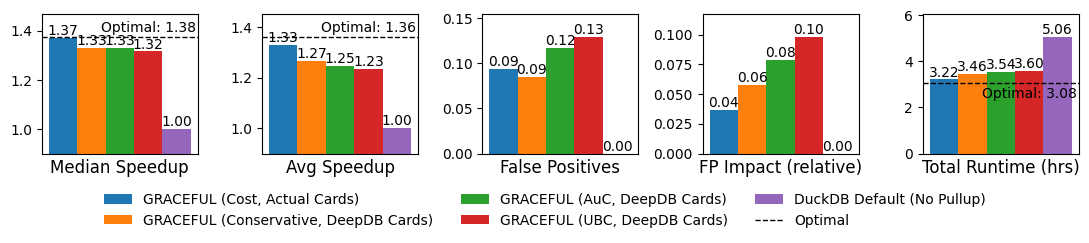

In [14]:
import matplotlib.pyplot as plt

# Data for the bar charts
elements = {
    'Optimum': {
        'Median Speedup': 1.375,
        'Avg Speedup': 1.361,
        'False Positive Ratio': 0.000,
        'FP Overhead (relative to total runtime)': 0.000,
        'Total Runtime (hrs)': 3.082
    },
    'GRACEFUL (Cost, Actual Cards)': {
        'Median Speedup': 1.370,
        'Avg Speedup': 1.330,
        'False Positive Ratio': 0.094,
        'FP Overhead (relative to total runtime)': 0.037,
        'Total Runtime (hrs)': 3.217
    },
    'GRACEFUL (Conservative, DeepDB Cards)': {
        'Median Speedup': 1.331,
        'Avg Speedup': 1.266,
        'False Positive Ratio': 0.085,
        'FP Overhead (relative to total runtime)': 0.058,
        'Total Runtime (hrs)': 3.460
    },
    'GRACEFUL (AuC, DeepDB Cards)': {
        'Median Speedup': 1.329,
        'Avg Speedup': 1.247,
        'False Positive Ratio': 0.117,
        'FP Overhead (relative to total runtime)': 0.079,
        'Total Runtime (hrs)': 3.536
    },
    'GRACEFUL (UBC, DeepDB Cards)': {
        'Median Speedup': 1.316,
        'Avg Speedup': 1.233,
        'False Positive Ratio': 0.129,
        'FP Overhead (relative to total runtime)': 0.098,
        'Total Runtime (hrs)': 3.595
    },
    'DuckDB Default (No Pullup)': {
        'Median Speedup': 1.000,
        'Avg Speedup': 1.000,
        'False Positive Ratio': 0.000,
        'FP Overhead (relative to total runtime)': 0.000,
        'Total Runtime (hrs)': 5.063
    }
}

# Creating subplots
fig, axs = plt.subplots(1, 5, figsize=(11, 2))

# Plotting each bar chart
titles = ['Median Speedup', 'Avg Speedup', 'False Positives', 'FP Impact (relative)','Total Runtime (hrs)']

median_speedup = [elements[key]['Median Speedup'] for key in elements]
avg_speedup = [elements[key]['Avg Speedup'] for key in elements]
false_positive_ratio = [elements[key]['False Positive Ratio'] for key in elements]
fp_overhead = [elements[key]['FP Overhead (relative to total runtime)'] for key in elements]
total_runtime = [elements[key]['Total Runtime (hrs)'] for key in elements]

data = [median_speedup, avg_speedup, false_positive_ratio, fp_overhead, total_runtime]

labels = list(elements.keys())

for i, ax in enumerate(axs):
    for j, label in enumerate(labels):
        if j==0:
            # skip optimal
            continue
        
        bar = ax.bar(label, data[i][j], label=label,width =1.0)
        # Add labels to the bars
        ax.text(bar[0].get_x() + bar[0].get_width() / 2, bar[0].get_height(), f'{data[i][j]:.2f}', ha='center', va='bottom')
    
    optimal = data[i][0]
    
    if optimal>0:
        ax.axhline(y=optimal, color='black', linestyle='--', linewidth=1, label='Optimal')
        
        if i == 4:
            y_offset=-0.8
        else:
            y_offset=0.01
        ax.text(0.685, optimal+y_offset, f'Optimal: {optimal:.2f}', color='black', ha='center', va='bottom', transform=ax.get_yaxis_transform())
    
    ax.set_title(titles[i], loc='center', x=0.5, y=-0.2)
    ax.set_xticks([])  # Do not show xticks

    # Start y-axis at 1
    max_val = max(data[i])

    if i < 2:
        min_val = 0.9
    else:
        min_val = 0
        
    max_val = (max_val - min_val) * 1.2 + min_val
    ax.set_ylim(min_val, max_val)

order = [1,2,3,4,5,0]
handles,labels = axs[0].get_legend_handles_labels()
fig.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.075), frameon=False)

# Add legend
# fig.legend(labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.075), frameon=False)

# Adjust layout
plt.tight_layout()
plt.savefig('results/pullup_pushdown_strategy_comp.pdf', bbox_inches='tight')